## Visualisation

In [548]:
import os
import cv2
import scipy
import skimage
import skimage.morphology
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from collections import defaultdict

In [2]:
# hepler functions

def colorize(img, color):
    color = np.array(color)
    return np.stack(3 * [img], axis=-1) * color

def blend(a, b ,c):
    return np.clip(a + b * 0.5 + c * 0.5, 0, 1)

In [7]:
# read all images

origin = {}
expert = {}
sample_1 = {}
sample_2 = {}
sample_3 = {}

base_path = "../data/Dataset"

for filename in os.listdir(os.path.join(base_path, "Origin")):
    tmp = filename.split(".")[0]
    origin[tmp] = plt.imread(os.path.join(base_path, "Origin", filename))
    if len(origin[tmp].shape) == 3:
        origin[tmp] = origin[tmp][:, :, 0]
    expert[tmp] = plt.imread(os.path.join(base_path, "Expert", f"{tmp}_expert.png"))
    sample_1[tmp] = plt.imread(os.path.join(base_path, "sample_1", f"{tmp}_s1.png"))
    sample_2[tmp] = plt.imread(os.path.join(base_path, "sample_2", f"{tmp}_s2.png"))
    sample_3[tmp] = plt.imread(os.path.join(base_path, "sample_3", f"{tmp}_s3.png"))
    
keys = list(sorted(origin.keys()))

In [325]:
# read all labels
f = open(os.path.join(base_path, "OpenPart.csv"))
scores = {}
next(f)
for line in f:
    key, values = line.split(",", 1)
    key = key.split(".")[0]
    scores[key] = values.strip().split(",")

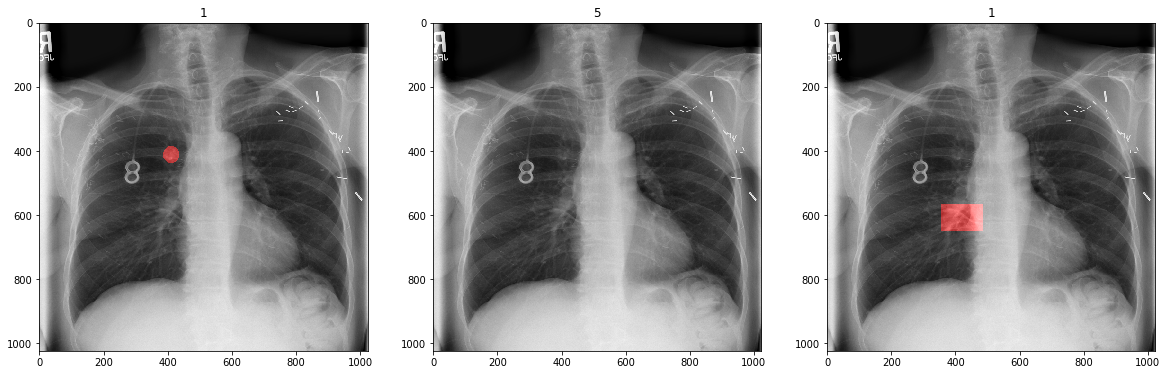

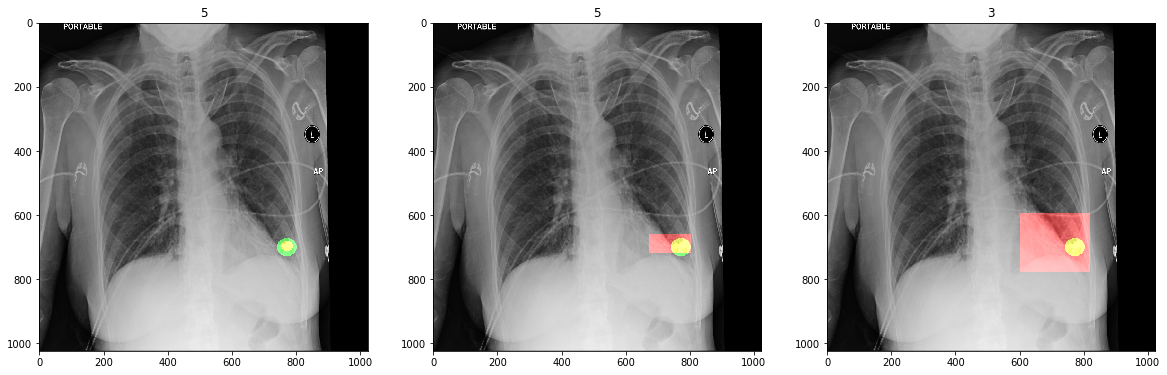

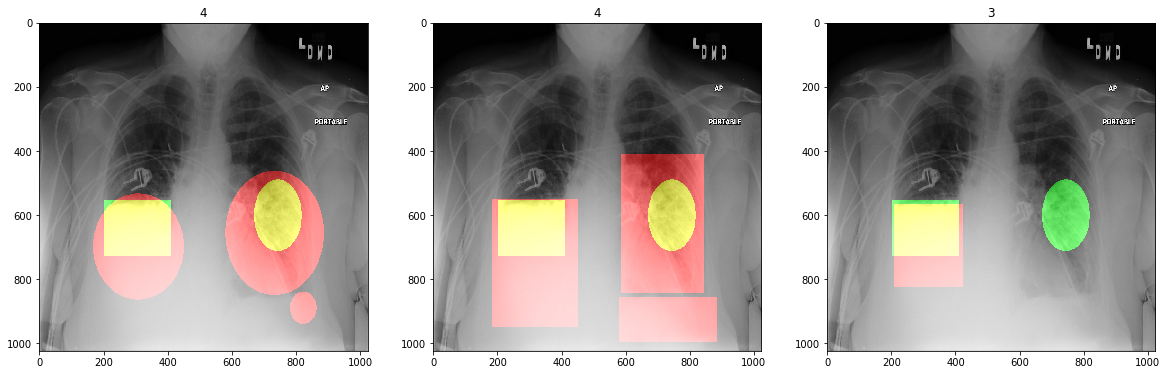

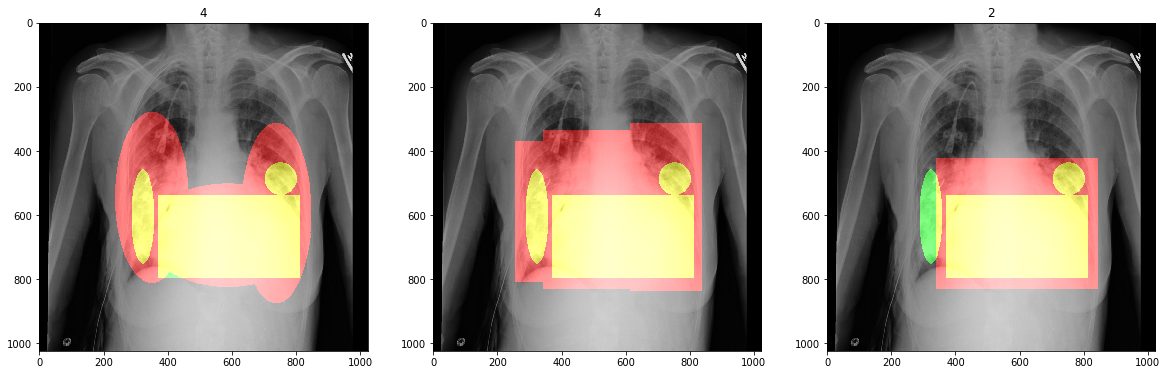

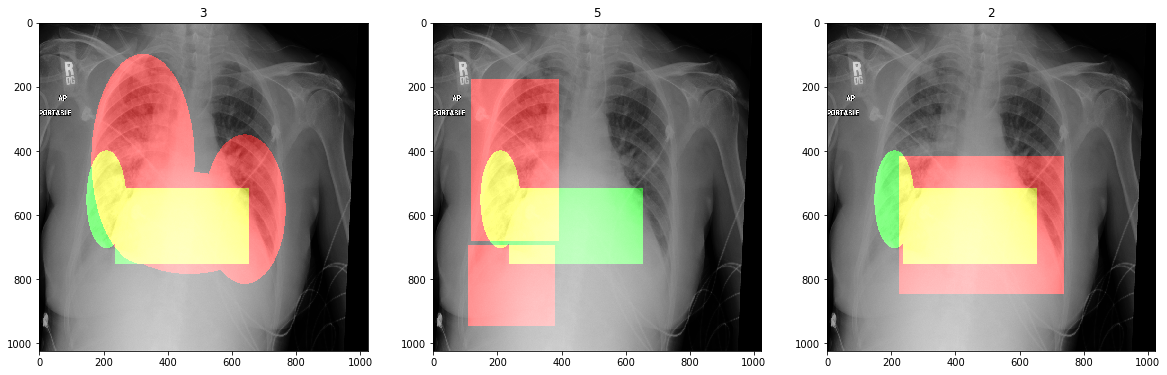

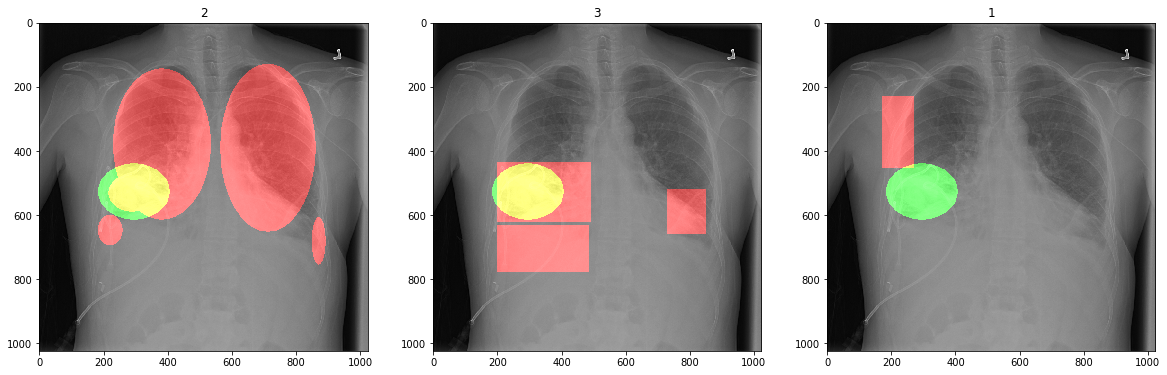

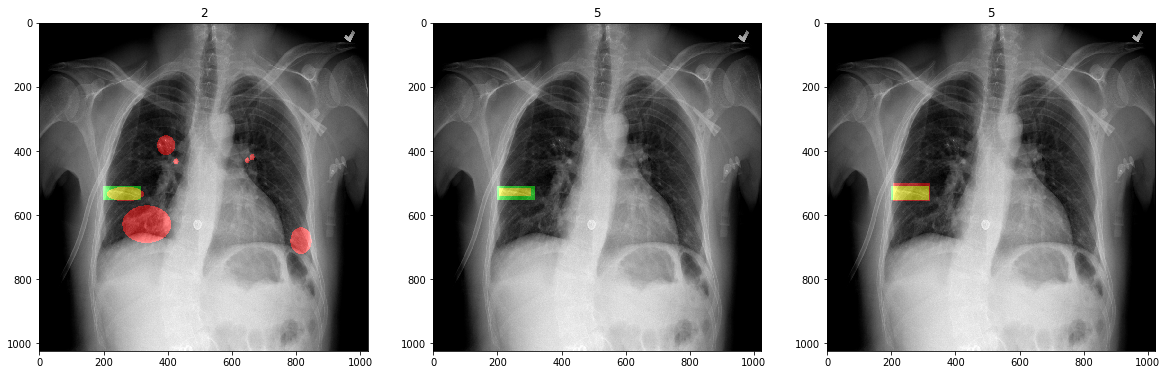

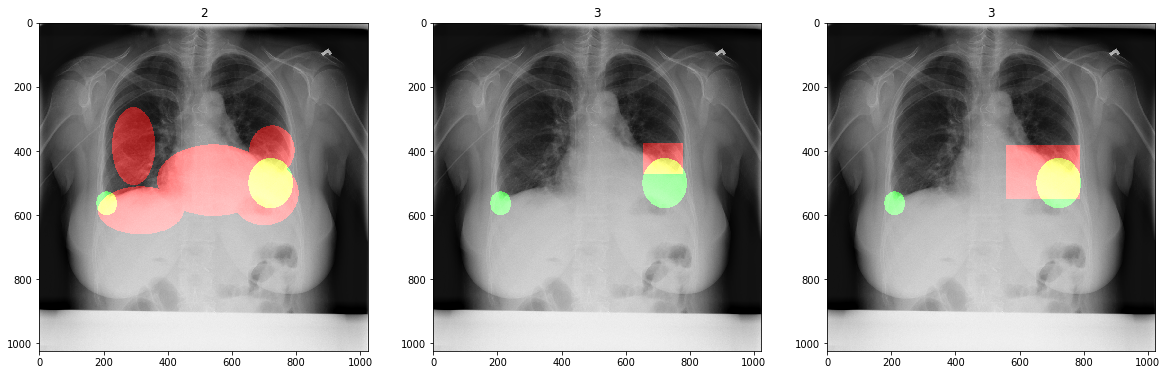

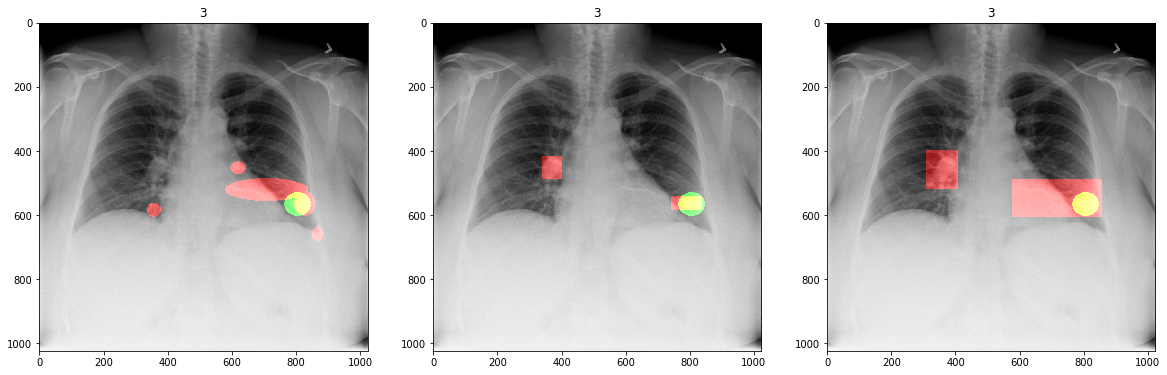

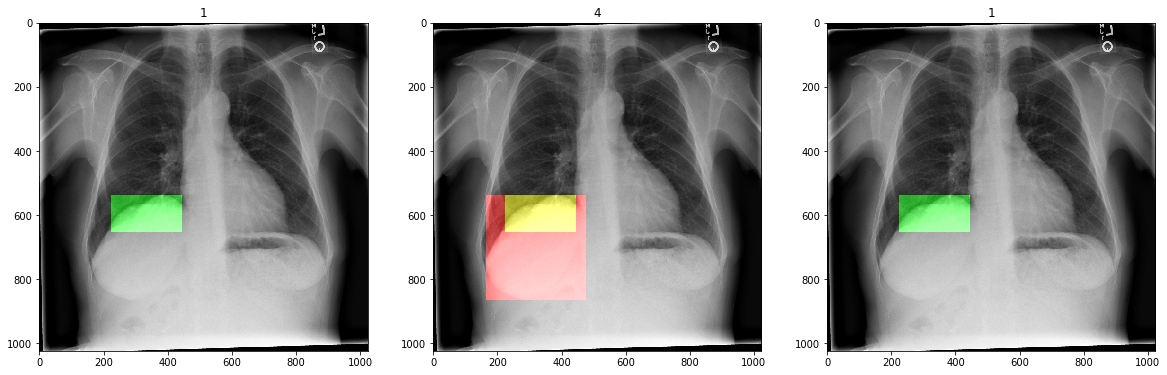

In [8]:
for key in keys[0:10]: 
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.imshow(
        blend(
            colorize(origin[key], [1, 1, 1]),
            colorize(expert[key], [0, 1, 0]),
            colorize(sample_1[key], [1, 0, 0])        
        )
    )
    plt.title(f"{scores[key][0] if key in scores else ''}")
    plt.subplot(132)
    plt.title(f"{scores[key][1] if key in scores else ''}")
    plt.imshow(
        blend(
            colorize(origin[key], [1, 1, 1]),
            colorize(expert[key], [0, 1, 0]),
            colorize(sample_2[key], [1, 0, 0])        
        )
    )
    plt.subplot(133)
    plt.imshow(
        blend(
            colorize(origin[key], [1, 1, 1]),
            colorize(expert[key], [0, 1, 0]),
            colorize(sample_3[key], [1, 0, 0])        
        )
    )
    plt.title(f"{scores[key][2] if key in scores else ''}")
    plt.show()

## Explore data

In [10]:
def get_iou(x1, x2):
    intersection = np.clip((x1 * x2), 0, 1).sum()
    union = np.clip((x1 + x2), 0, 1).sum()
    
    if intersection == 0 and union == 0:
        iou = 1.
    elif union == 0:
        iou = 0.
    else:
        iou = intersection / union
    return iou

In [11]:
train_keys = set(scores.keys())
test_keys = set(origin.keys()).difference(train_keys)

assert len(train_keys) == 60
assert len(test_keys) == 40
assert not train_keys.intersection(test_keys)

In [15]:
ious_per_score = defaultdict(list)

for k in train_keys:
    
    expert_mask = expert[k]
    ai_masks = [sample_1[k], sample_2[k], sample_3[k]]
    ai_scores = scores[k]
    
    for ai_mask, ai_socre in zip(ai_masks, ai_scores):
        iou = get_iou(expert_mask, ai_mask)
        ious_per_score[ai_socre].append(iou)

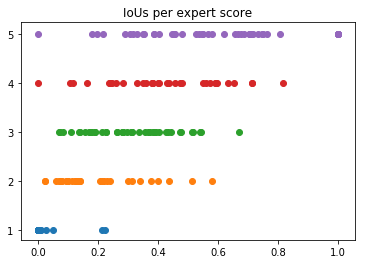

In [18]:
for score in sorted(ious_per_score.keys()):
    ious = ious_per_score[score]
    plt.scatter(x=ious, y=[score] * len(ious))
plt.title("IoUs per expert score")
plt.show()

In [458]:
# Precision helper function
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn


def get_instance_iou(gt, pr, thresholds, beta=1, verbose=1):
    """
    Calculate instance-wise F-score in range(0.5, 1, 0.05)
    
    Source:
        https://github.com/selimsef/dsb2018_topcoders/blob/master/selim/metric.py
        
    Args:
        gt: ground truth instances mask (each instance has its own unique value)
        pr: predicted instances mask (each instance has its own unique value)
        beta: F-score beta coeffitient
        verbose: verbosity level
        
    Returns:
        score: float
    """
    
    # separate instances
    gt = skimage.measure.label(gt)
    pr = skimage.measure.label(pr)

    print_fn = lambda x: print(x) if verbose else None
    
    true_objects = len(np.unique(gt))
    pred_objects = len(np.unique(pr)) 
    
    # Compute intersection between all objects
    intersection = np.histogram2d(gt.flatten(), pr.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(gt, bins = true_objects)[0]
    area_pred = np.histogram(pr, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection 
    
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union   

    # Loop over IoU thresholds
    prec = []
    print_fn("Thresh\tTP\tFP\tFN\tPrec.")
    for t in thresholds:
        tp, fp, fn = precision_at(t, iou)
        if tp + fp + fn == 0:
            p = 1.
        else:
            p = (1 + beta**2) * tp / ((1 + beta**2) * tp + fp + beta**2 * fn + 1e-10)
        print_fn("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    print_fn("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    
    return prec

In [101]:
ious_per_score = defaultdict(list)

with tqdm(train_keys) as train_keys_:
    for k in train_keys_:

        expert_mask = expert[k]
        ai_masks = [sample_1[k], sample_2[k], sample_3[k]]
        ai_scores = scores[k]

        for ai_mask, ai_socre in zip(ai_masks, ai_scores):
            thresholds = np.arange(0.0, 1.0, 0.1)
            ious = get_instance_iou(expert_mask, ai_mask, thresholds, verbose=False)
            iou = np.mean(ious)
            ious_per_score[ai_socre].append(iou)

100%|██████████| 60/60 [00:16<00:00,  3.69it/s]


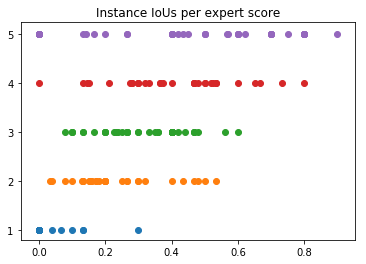

In [102]:
for score in sorted(ious_per_score.keys()):
    ious = ious_per_score[score]
    plt.scatter(x=ious, y=[score] * len(ious))
plt.title("Instance IoUs per expert score")
plt.show()

## Expert mask heatmap

In [48]:
expert_mask = np.stack(expert.values(), axis=-1).astype("float").sum(-1)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3248: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


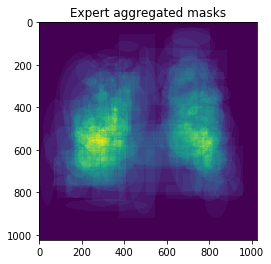

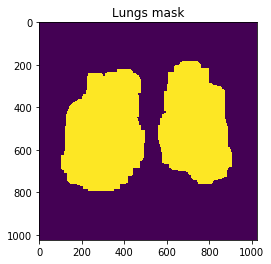

In [78]:
plt.imshow(expert_mask)
plt.title("Expert aggregated masks")
plt.show()

lungs_mask = (expert_mask > 10).astype("uint8")
lungs_mask = cv2.dilate(lungs_mask, np.ones([3, 3]), iterations=30)
plt.imshow(lungs_mask)
plt.title("Lungs mask")
plt.show()

## Features per zones

In [454]:
def split_mask_to_zones(mask, lungs_labeled_mask, intersection_threshold=0.3):
    
    # split lungs mask to separate masks, one area for each mask
    lung_labels = [0, 1, 2]
    assert np.unique(lungs_labeled_mask).tolist() == lung_labels
    
    lung_areas = [lungs_labeled_mask == label for label in lung_labels]
    
    # placeholder for result
    background_mask = np.zeros_like(mask)
    left_lung_mask = np.zeros_like(mask)
    right_lung_mask = np.zeros_like(mask)
    mask_areas = [background_mask, left_lung_mask, right_lung_mask]
    
    # extract instances from mask
    labeled_mask = skimage.measure.label(mask)
    mask_labels = np.unique(labeled_mask)[1:] # to remove background
    
    for label in mask_labels:
        
        one_instance_mask = (labeled_mask == label)
        one_instance_sum = one_instance_mask.sum()
        
        for area_label in [0, 1, 2]:  # 0 - backgound, 1 - left lung, 2 - right
            intersection = one_instance_mask * lung_areas[area_label]
            if intersection.sum() / one_instance_sum > intersection_threshold:
                mask_areas[area_label] += intersection
                
    return mask_areas

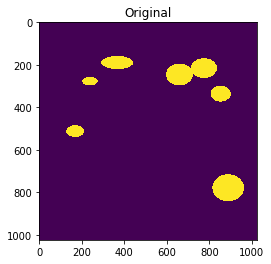

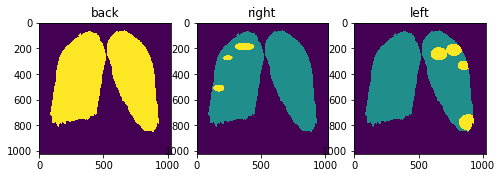

In [456]:
key = keys[40]
mask = expert[key]
lungs_labeled_mask = skimage.io.imread("../data/average_mask.png")#[..., 0]#skimage.measure.label(lungs_mask)

splitted_masks = split_mask_to_zones(mask, lungs_labeled_mask, intersection_threshold=0.3)

plt.imshow(mask)
plt.title("Original")
plt.show()

plt.figure(figsize=(8, 8))
for i, (name, mask) in enumerate(zip(["back", "right", "left"], splitted_masks)):
    plt.subplot(1, 3, i+1)
    result = np.clip(lungs_labeled_mask, 0, 1) * 127
    result[mask.astype("bool")] = 255
    plt.imshow(result)
    plt.title(name)
plt.show()

In [688]:
# calculate IoU based on areas

ious_per_score = defaultdict(list)
lungs_labeled_mask = skimage.io.imread("../data/average_mask.png") #skimage.measure.label(lungs_mask)
features = []
thresholds = np.arange(0, 1, 0.1)
data = []


with tqdm(keys) as keys_:
    for key in keys_:
        
#         lungs_labeled_mask = skimage.io.imread(f"../data/lungs_masks/{key}.png")
        expert_mask = expert[key]
        expert_masks = split_mask_to_zones(expert_mask, lungs_labeled_mask, intersection_threshold=0.3)

        for i, sample_dict in enumerate([sample_1, sample_2, sample_3]):
            sample_mask = sample_dict[key]
            
            # estimate ious per area
            sample_masks = split_mask_to_zones(sample_mask, lungs_labeled_mask, intersection_threshold=0.3)

            ious_1 = [get_iou(em, sm) for em, sm in zip(expert_masks, sample_masks)]
            ious_2 = [np.mean(get_instance_iou(em, sm, thresholds=thresholds, verbose=False)) for em, sm in zip(expert_masks, sample_masks)]
            score = scores[key][i] if key in scores else ""
            ious_per_score[i].append(ious)
            
            features.append([ious_0 + ious_1 + ious_2, score])
            
            sample = dict(
                key = key,
                sample_i = i,
                overall_iou = get_iou(expert_mask, sample_mask),
                overall_instance_iou = np.mean(get_instance_iou(expert_mask, sample_mask, thresholds=thresholds, verbose=0)),
                back_iou = ious_1[0],
                left_lung_iou = ious_1[1],
                right_lung_iou = ious_1[2],
                back_instance_iou = ious_2[0],
                left_lung_inst_iou = ious_2[1],
                right_lung_inst_iou = ious_2[2],
                target = score,
            )
            data.append(sample)

100%|██████████| 100/100 [02:05<00:00,  1.26s/it]


In [690]:
df = pd.DataFrame(data, columns=data[0].keys())
df.head()

key  sample_i  overall_iou  overall_instance_iou  back_iou  \
0  00000072_000         0     0.000000                   0.0       1.0   
1  00000072_000         1     1.000000                   1.0       1.0   
2  00000072_000         2     0.000000                   0.0       1.0   
3  00000150_002         0     0.351411                   0.4       1.0   
4  00000150_002         1     0.306655                   0.4       1.0   

   left_lung_iou  right_lung_iou  back_instance_iou  left_lung_inst_iou  \
0            0.0        1.000000                1.0                 0.0   
1            1.0        1.000000                1.0                 1.0   
2            0.0        1.000000                1.0                 0.0   
3            1.0        0.351411                1.0                 1.0   
4            1.0        0.380907                1.0                 1.0   

   right_lung_inst_iou target  
0                  1.0      1  
1                  1.0      5  
2                  1.0      1  
3                  0.4      5  
4                  0.4      5

In [691]:
df.to_csv("../data/iou_features_v01.csv", index=False)

## BaseLine

In [708]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

In [640]:
df_train = df[df.target != '']

In [655]:
X = df_train.to_numpy()[:, 2:-1]
y = df_train.to_numpy()[:, -1].astype("uint8")
groups = df_train["key"]

cv = sklearn.model_selection.GroupKFold(n_splits=10).split(X, y, groups)

In [754]:
cv = sklearn.model_selection.GroupKFold(n_splits=10).split(X, y, groups)
reg = RandomForestRegressor(n_estimators=3, max_depth=5)
# reg = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=2, random_state=0, loss='ls', criterion="mae")
reg_scores = cross_val_score(
    reg,
    X, y,
    cv=cv, 
    scoring=sklearn.metrics.make_scorer(sklearn.metrics.mean_absolute_error, greater_is_better=False)
)

print(f"{np.mean(reg_scores):.2}  {np.std(reg_scores):.2}")

-0.59  0.16


In [755]:
reg.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=3, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [751]:
df_test= df[df.target == '']
X_test = df_test.to_numpy()[:, 2:-1]
y_test = reg.predict(X_test).round(2)

In [752]:
df_test["target"] = y_test

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



# Visualize predictions

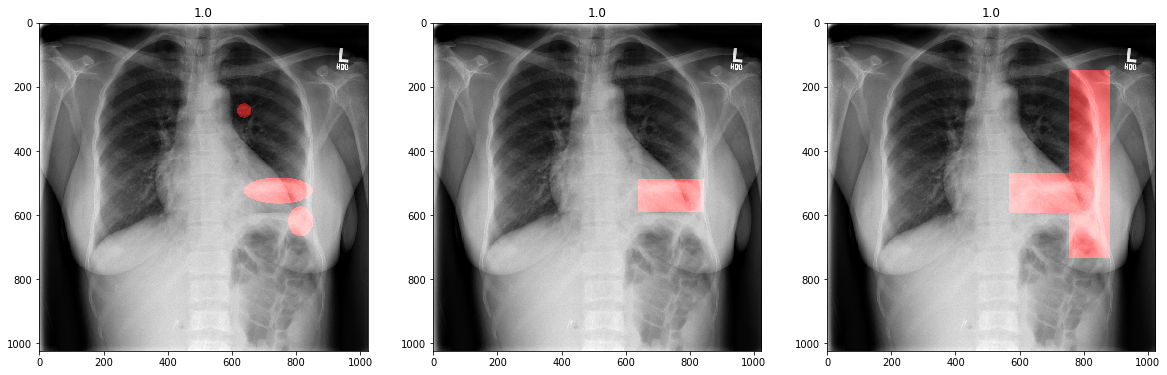

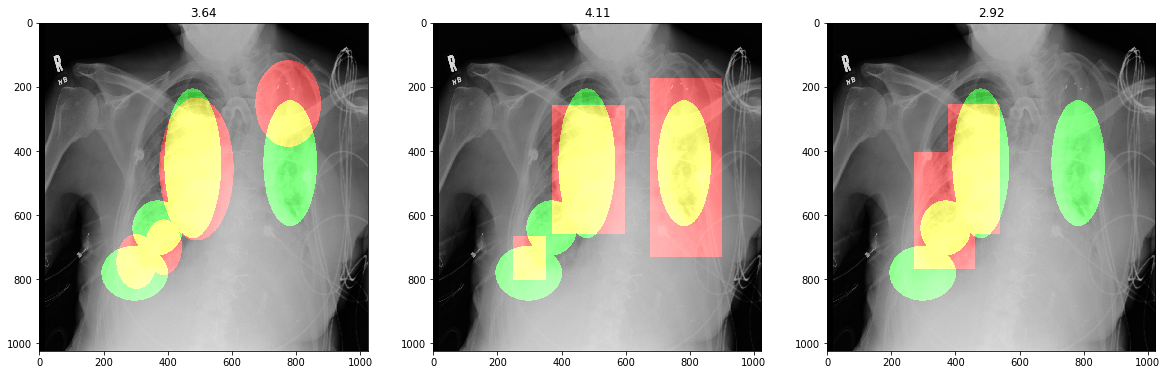

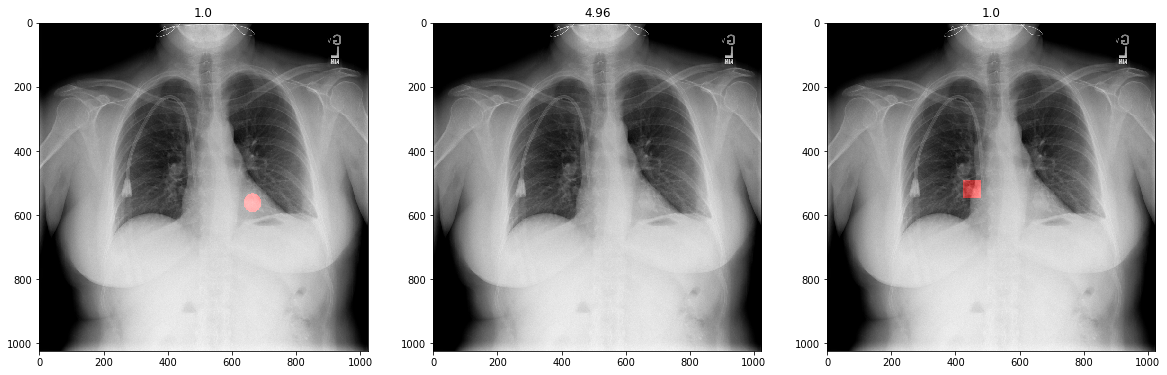

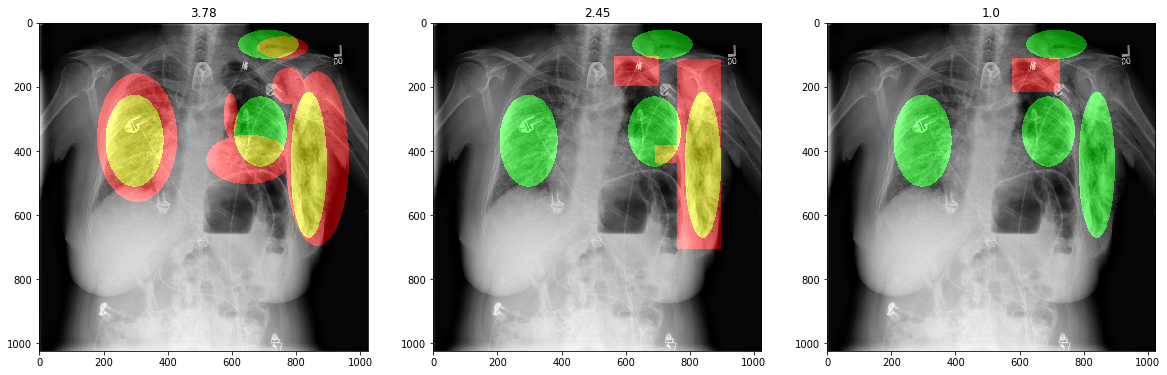

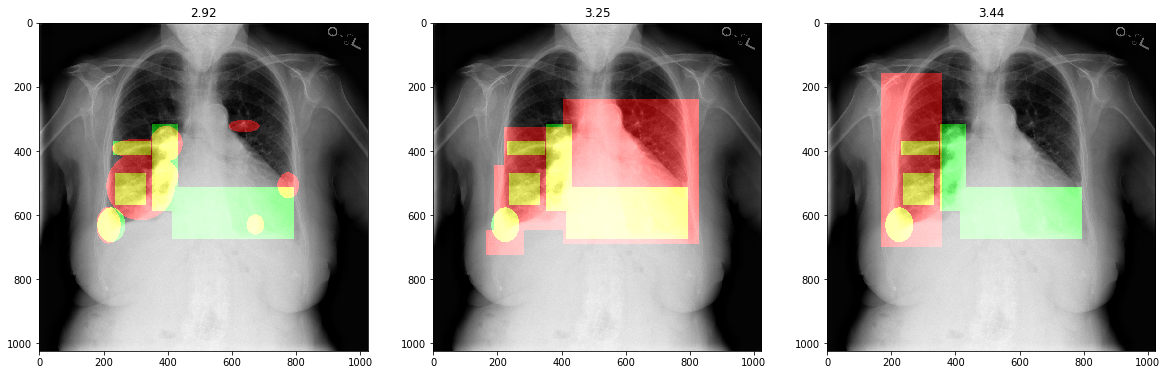

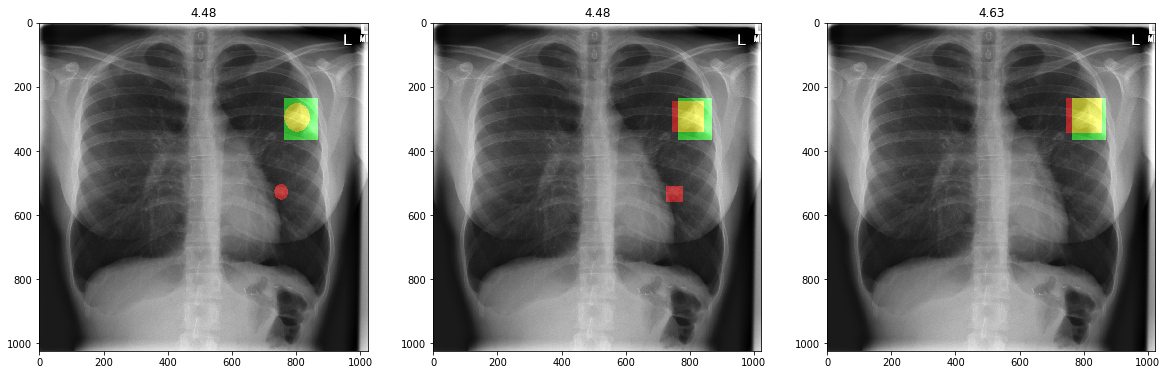

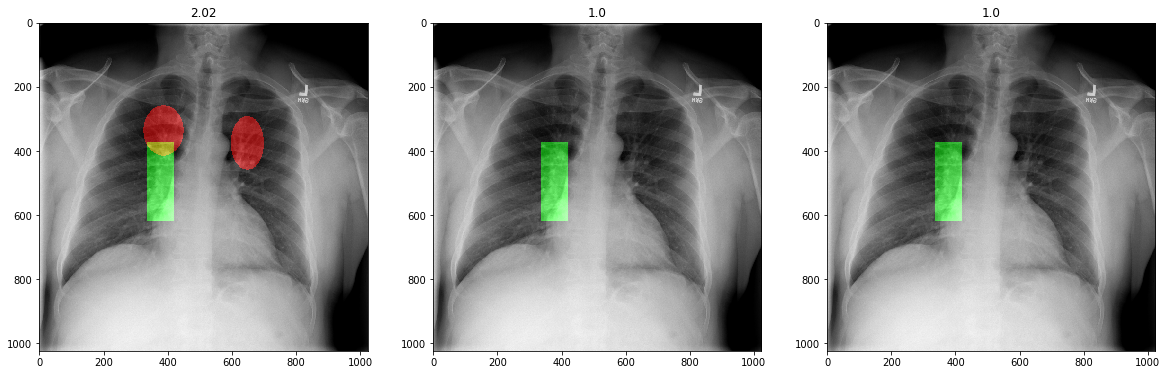

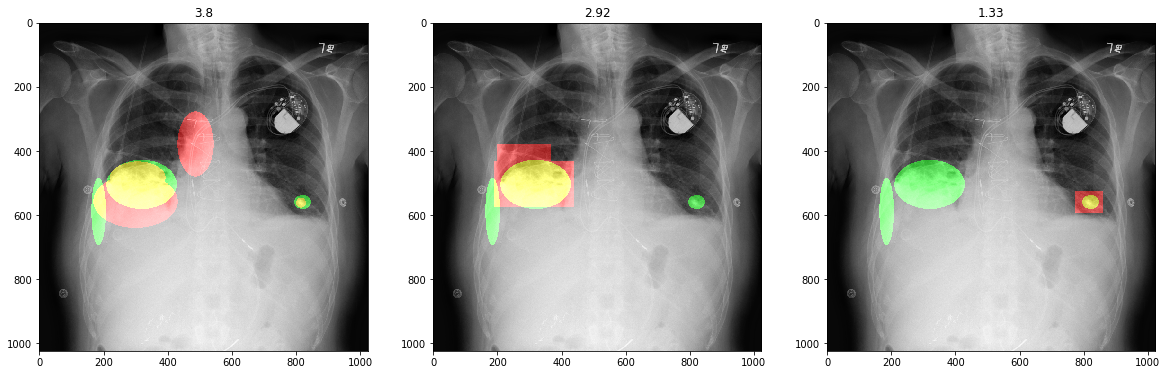

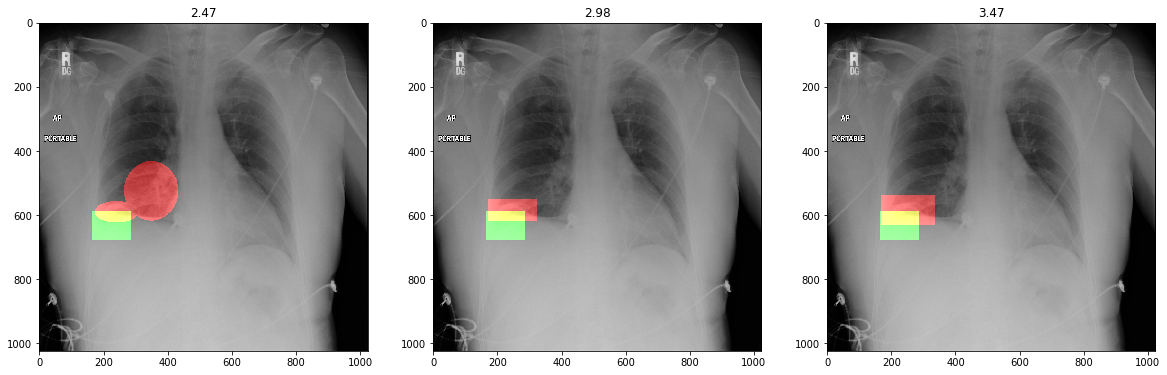

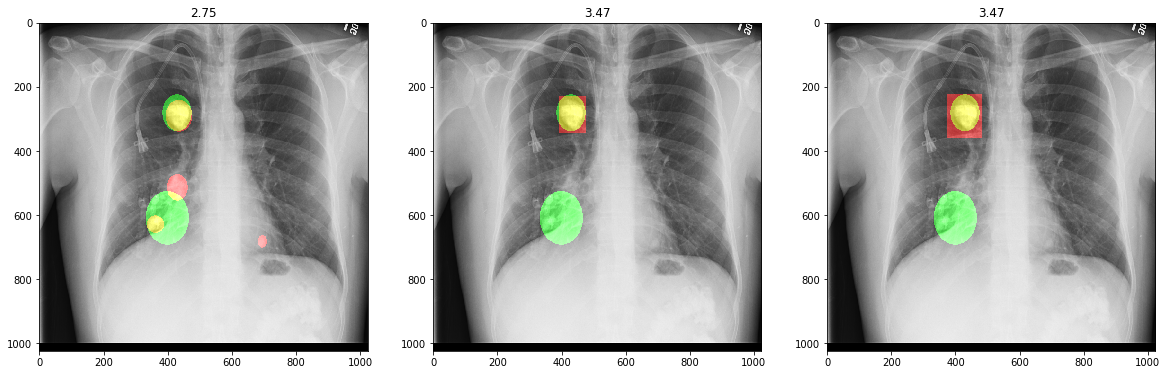

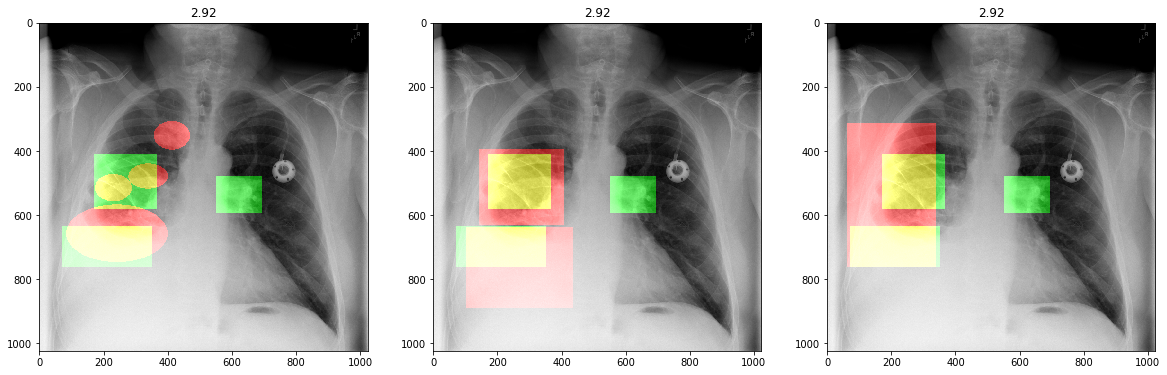

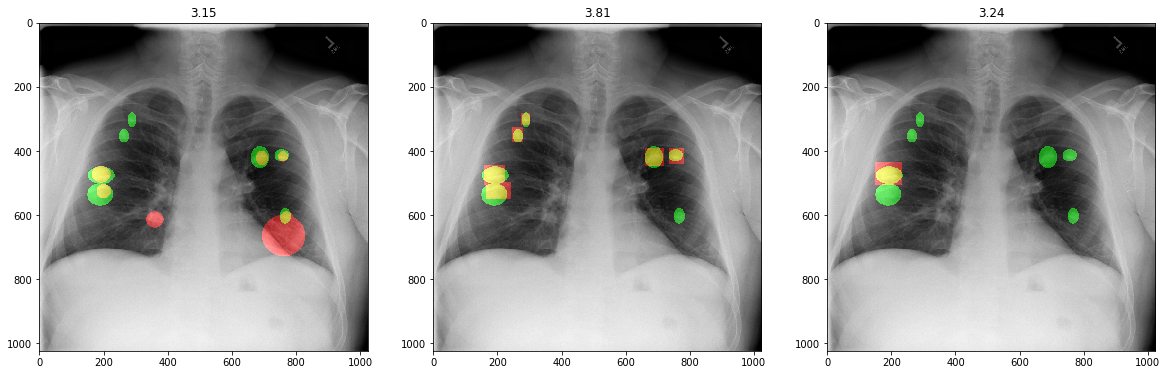

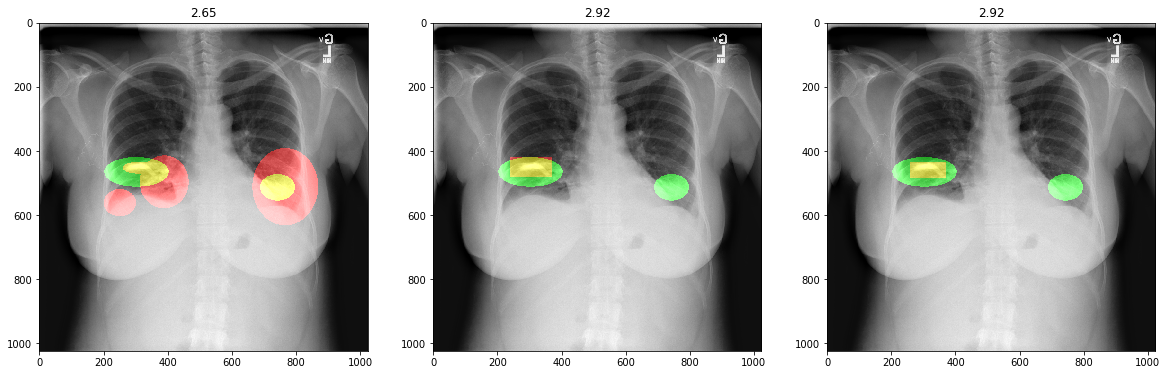

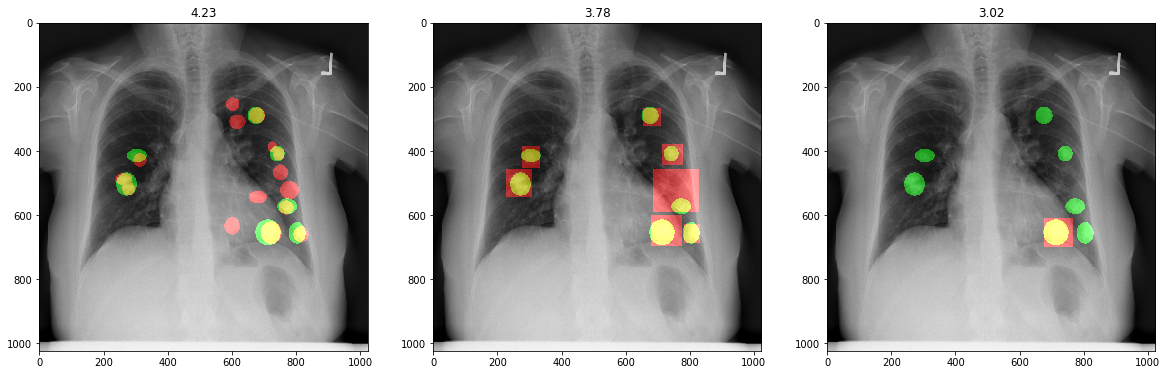

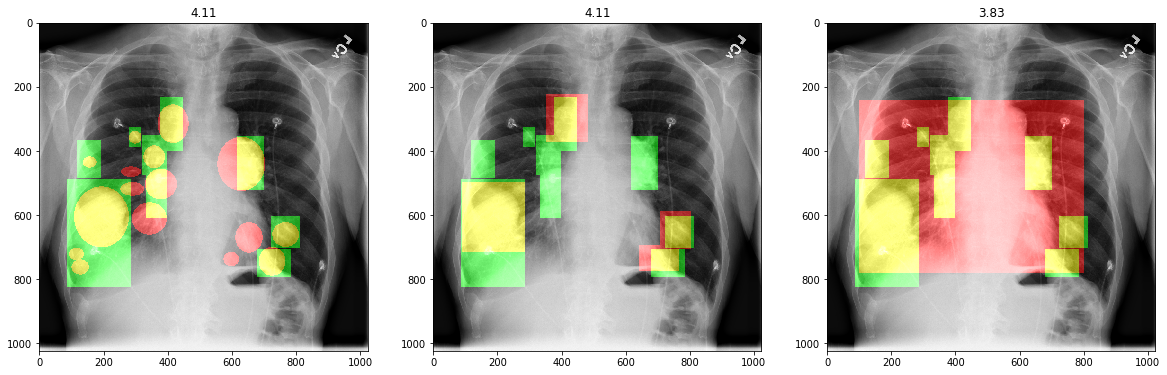

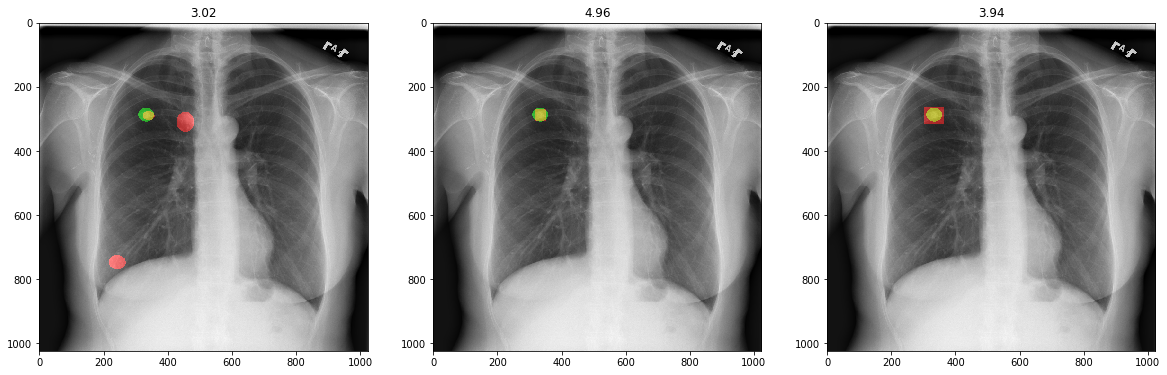

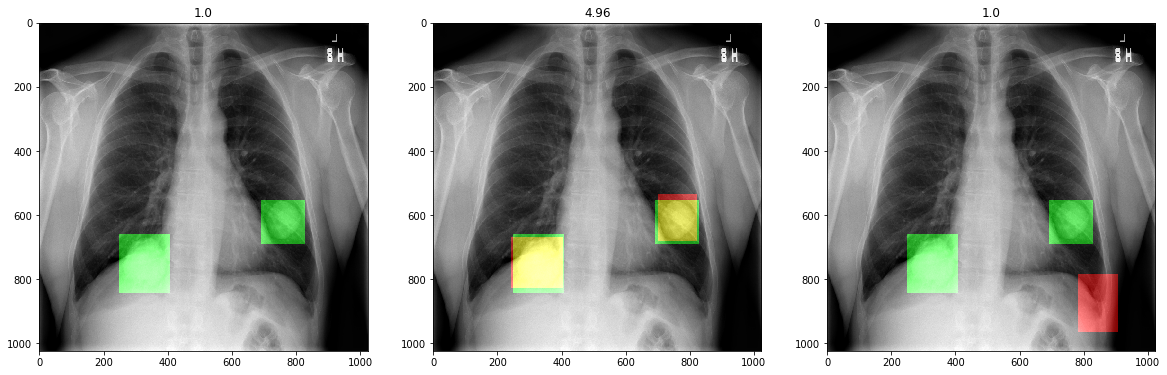

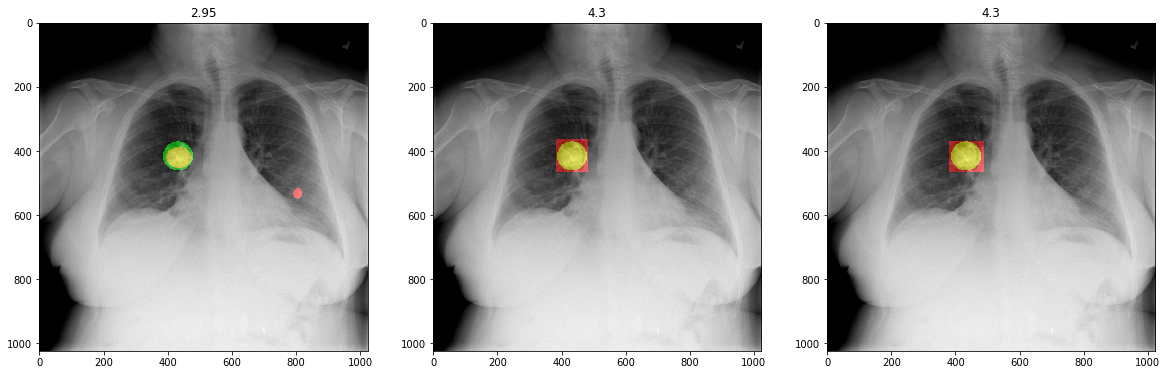

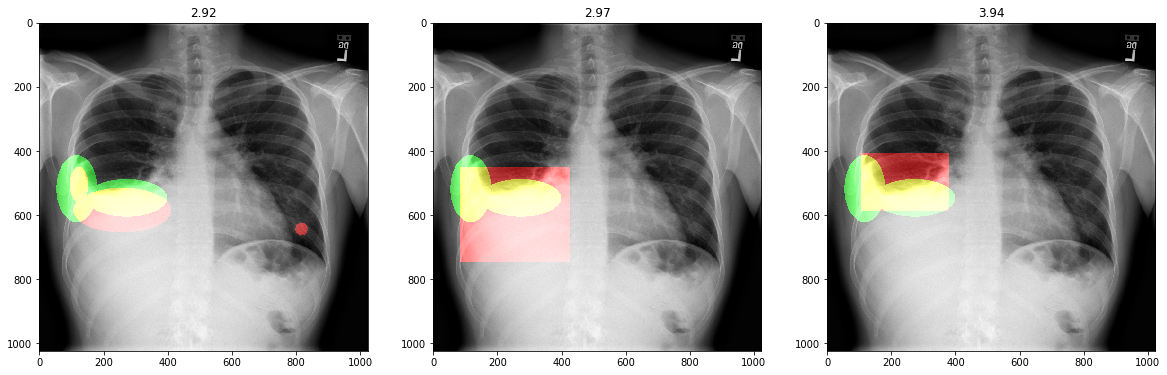

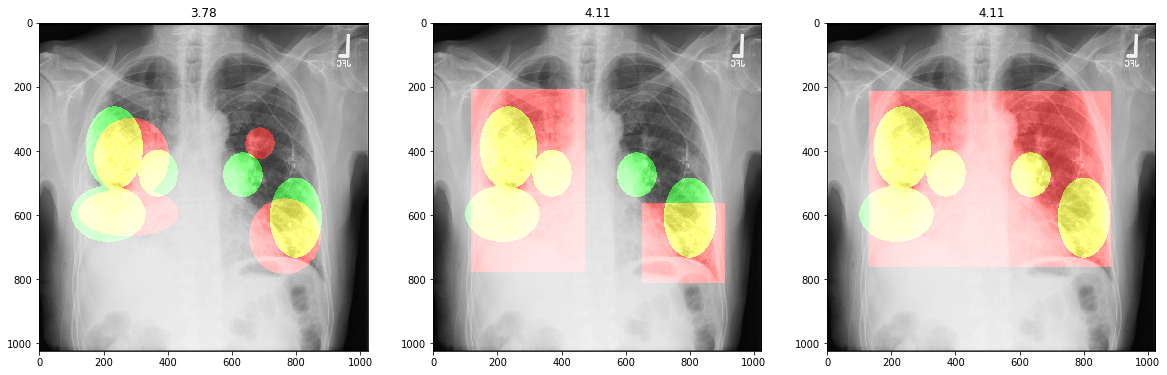

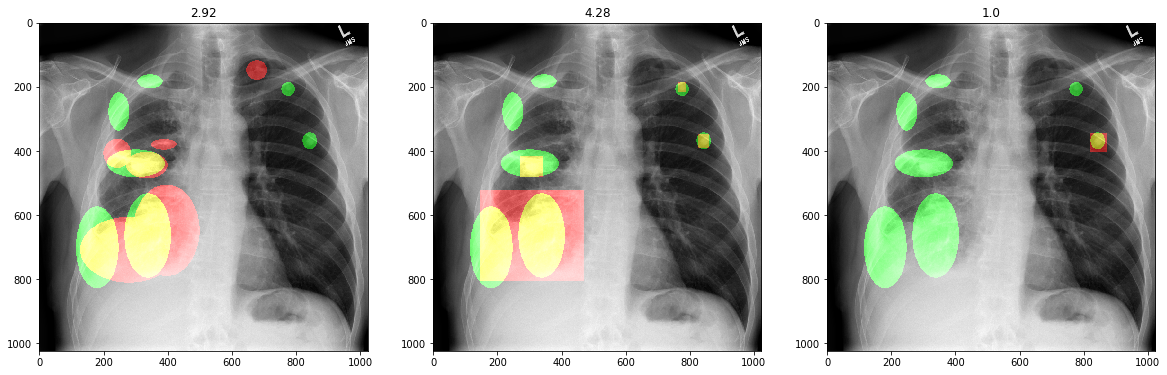

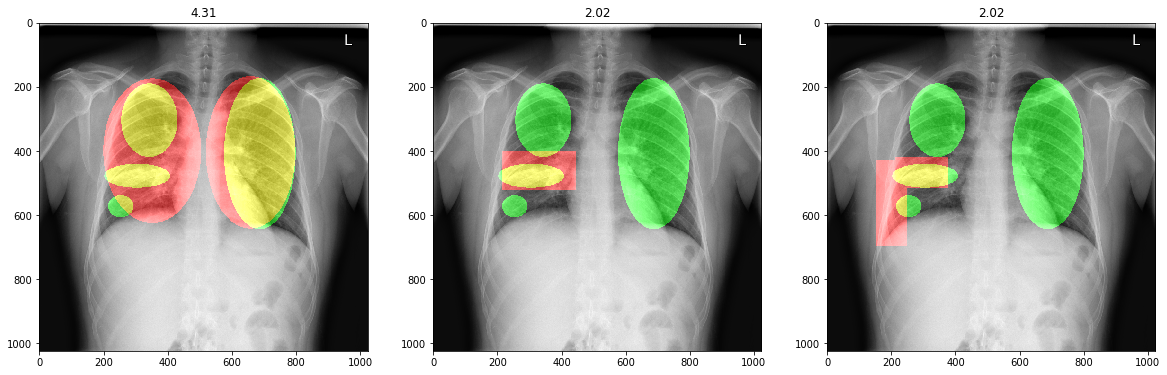

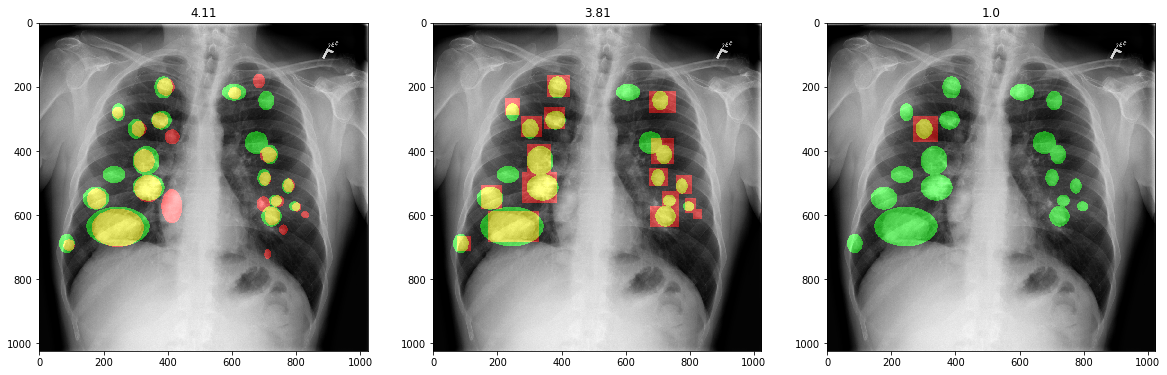

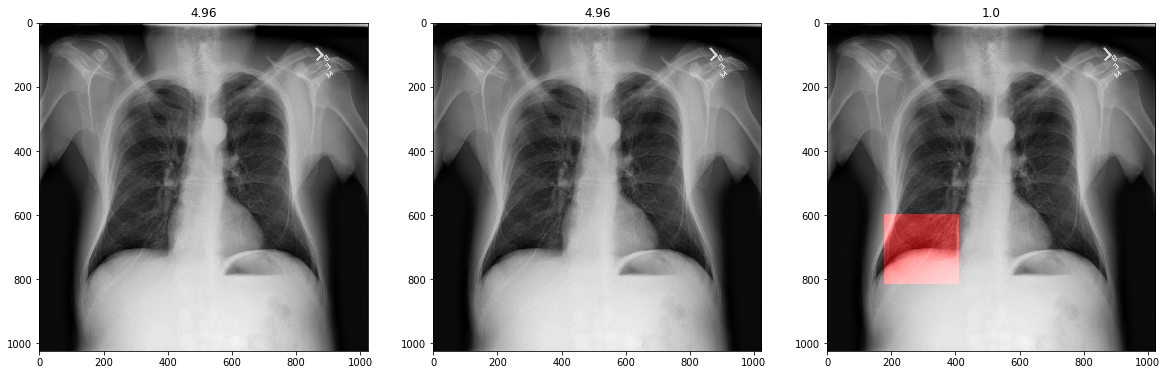

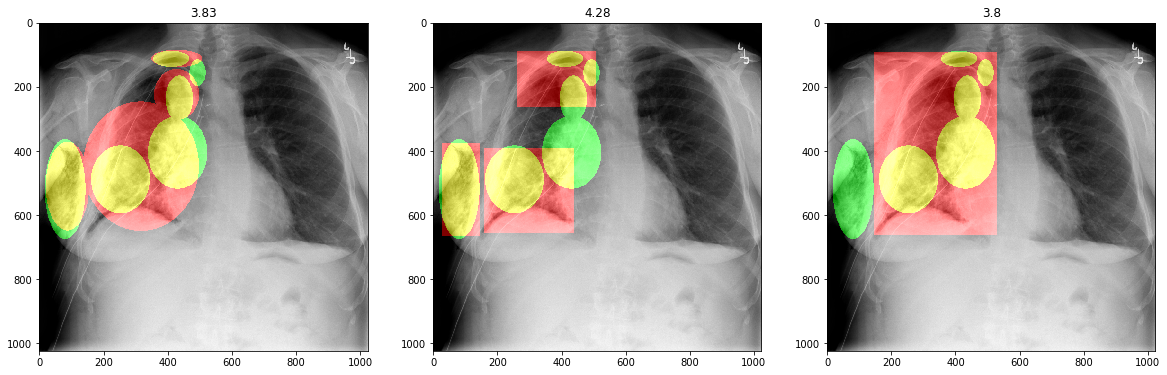

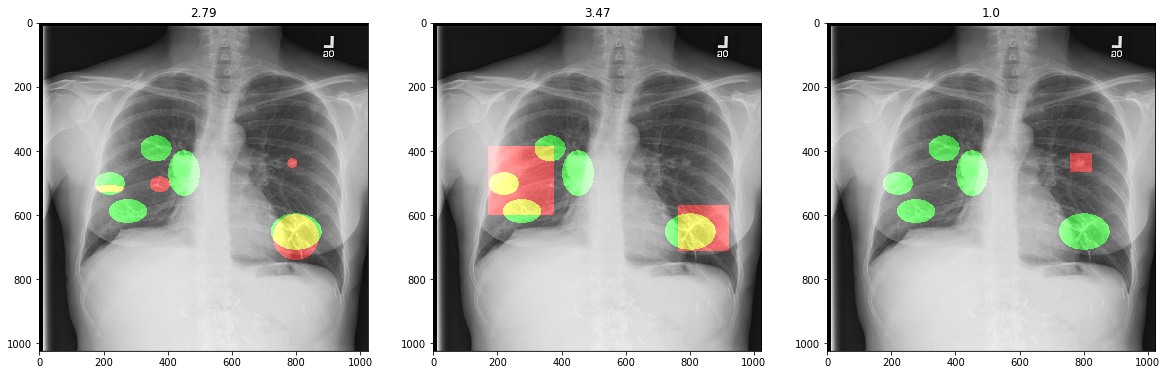

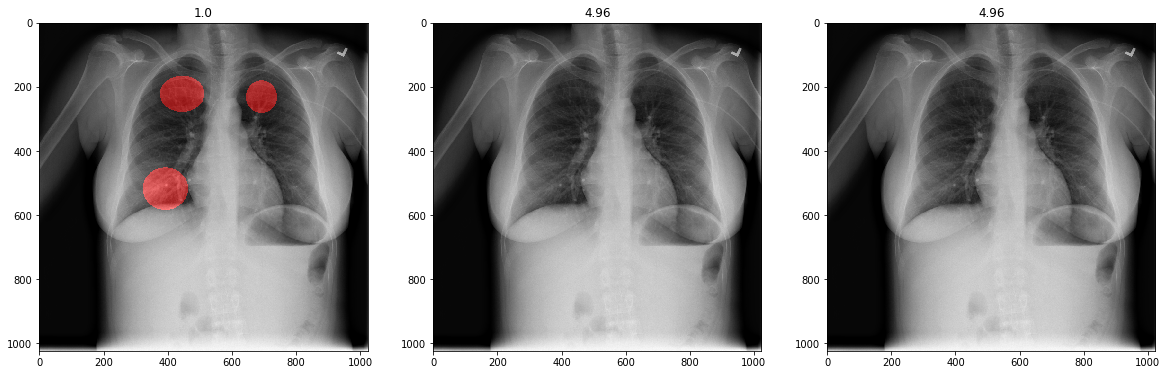

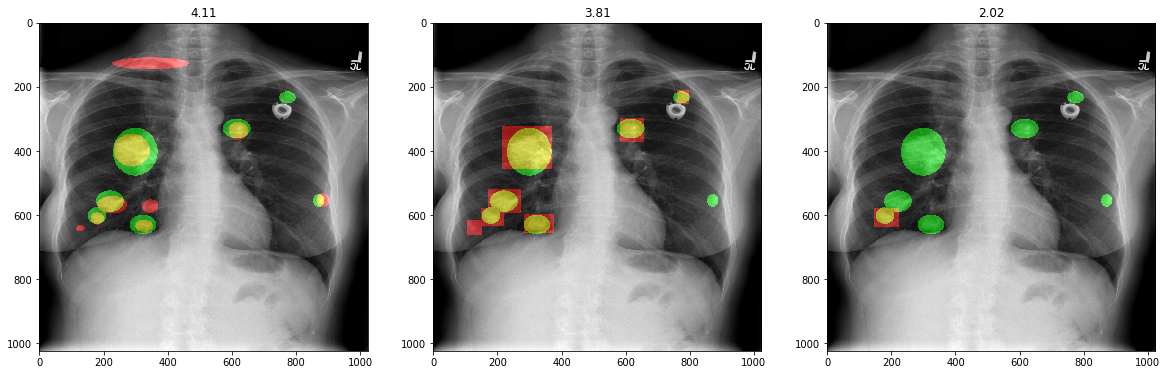

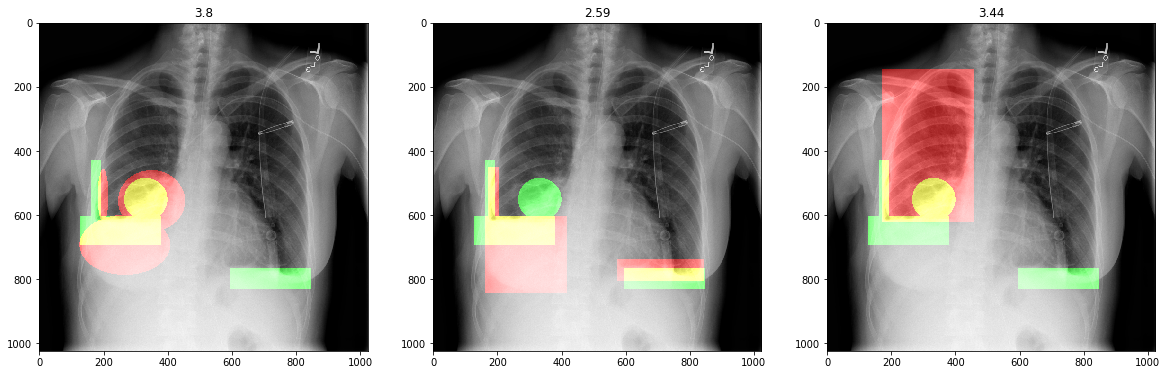

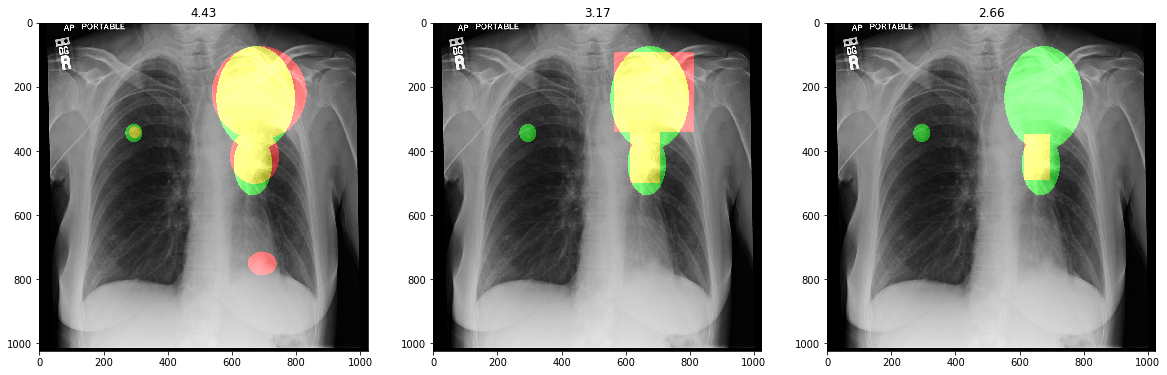

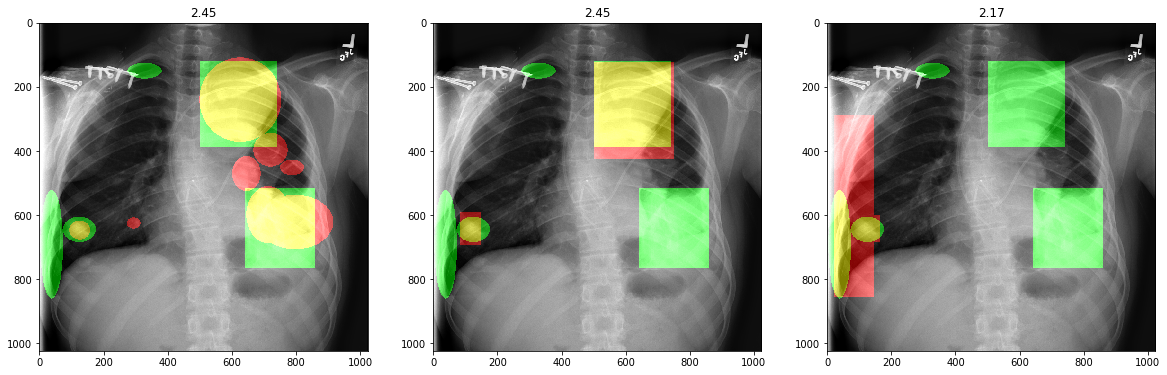

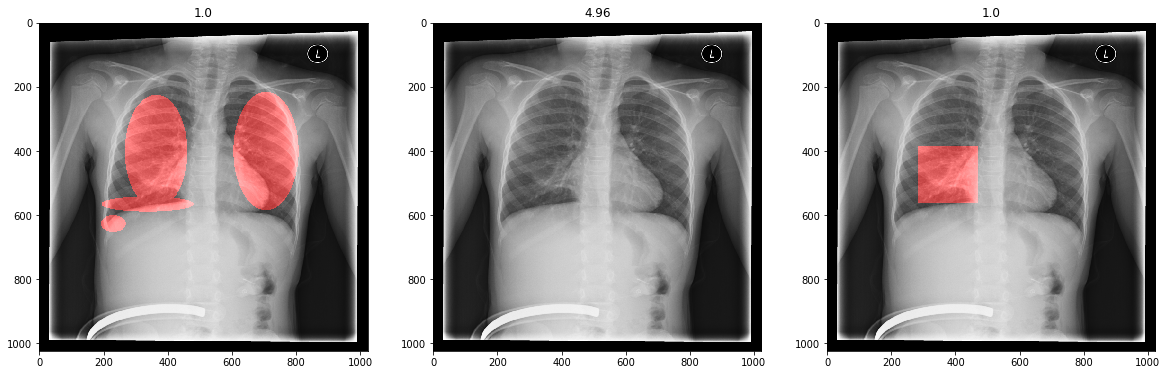

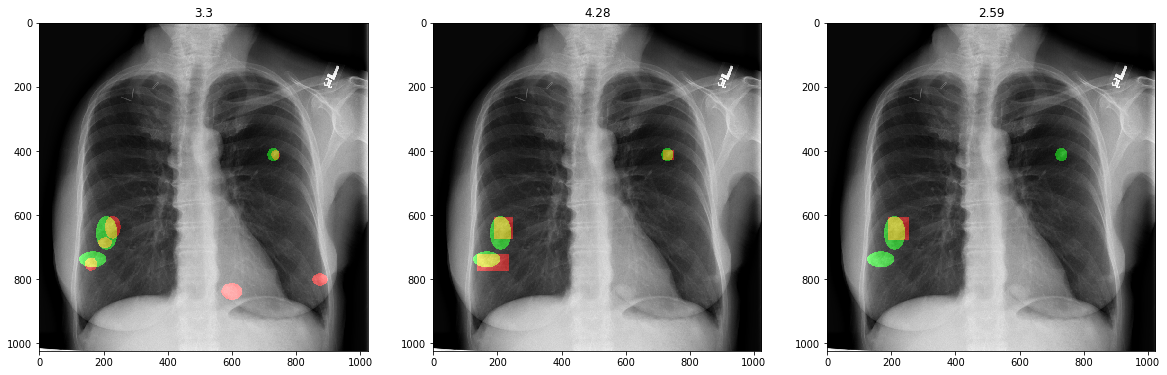

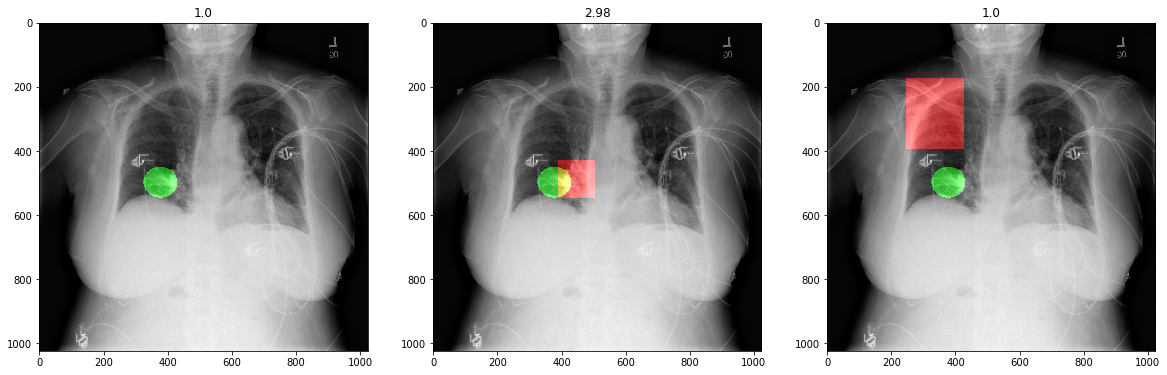

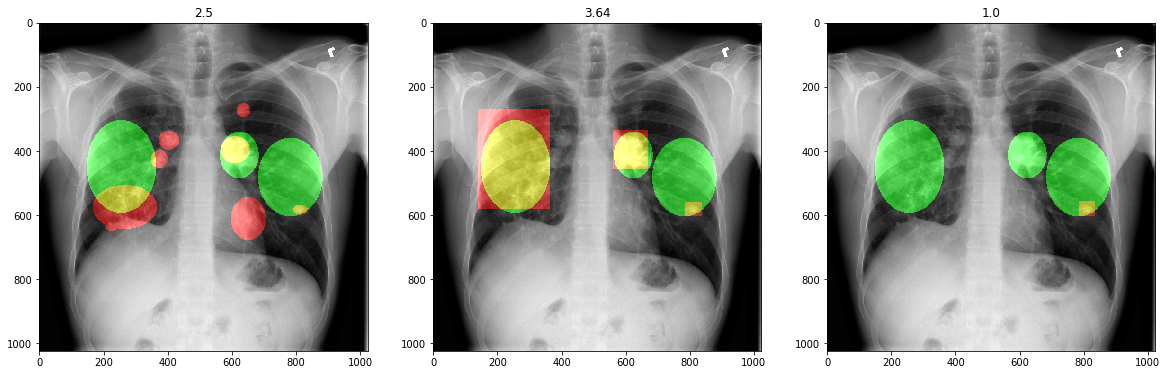

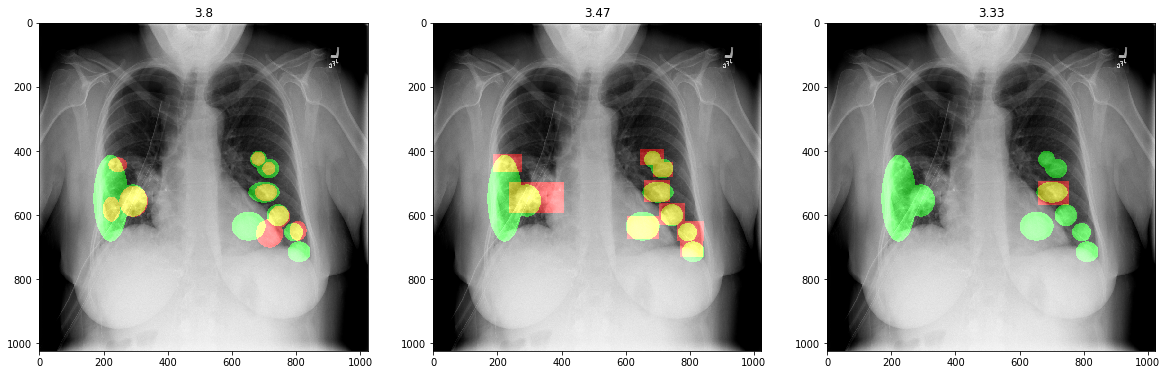

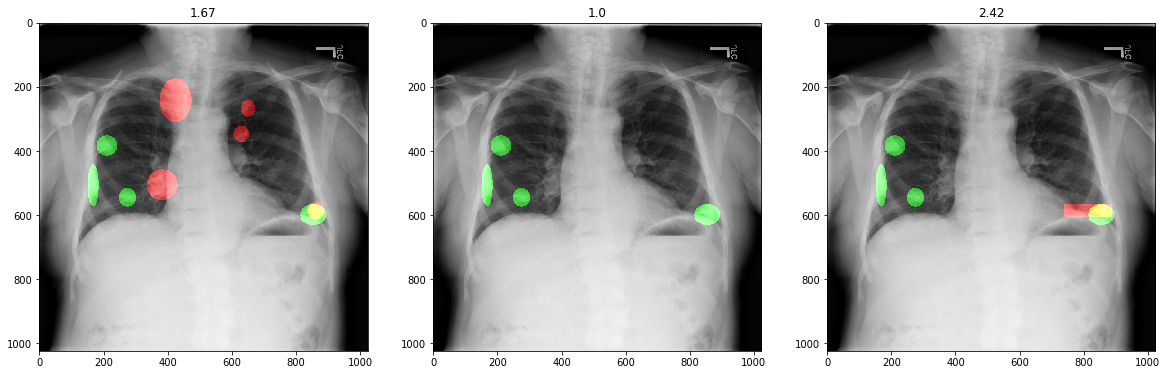

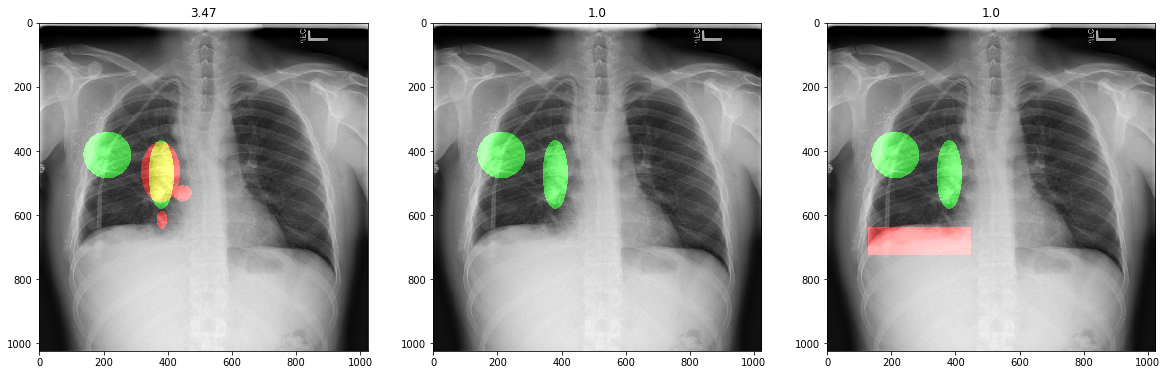

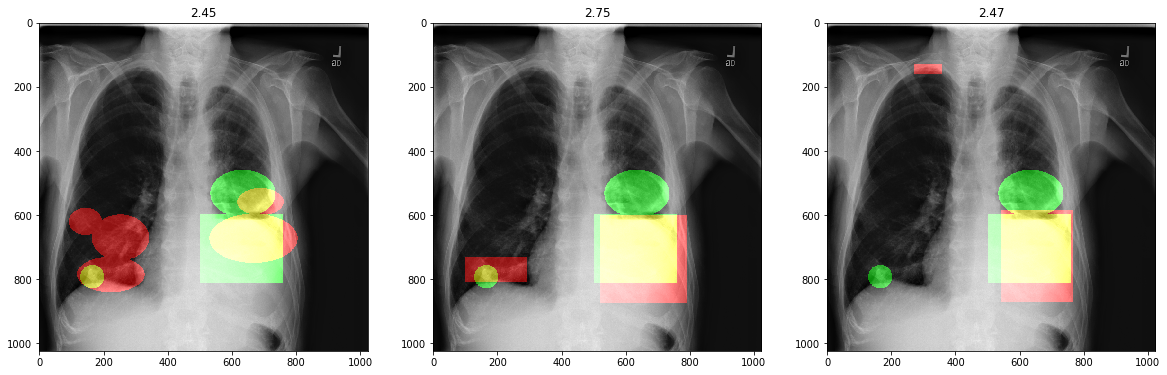

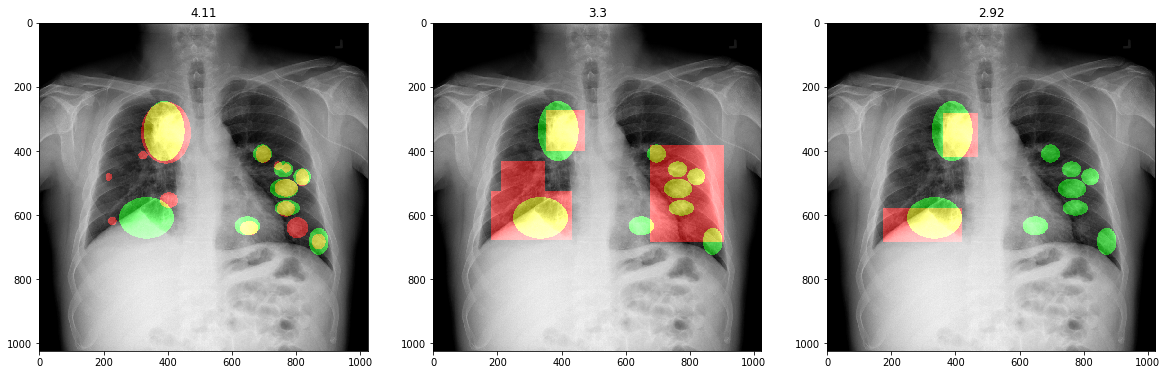

In [753]:
test_keys = df_test["key"].unique()

def get_test_score(df, key, i):
    return df[(df.key == key) & (df.sample_i == i)]["target"].values[0]

for key in test_keys: 
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.title(f"{get_test_score(df_test, key, 0)}")
    plt.imshow(
        blend(
            colorize(origin[key], [1, 1, 1]),
            colorize(expert[key], [0, 1, 0]),
            colorize(sample_1[key], [1, 0, 0])        
        )
    )
    
    plt.subplot(132)
    plt.title(f"{get_test_score(df_test, key, 1)}")
    plt.imshow(
        blend(
            colorize(origin[key], [1, 1, 1]),
            colorize(expert[key], [0, 1, 0]),
            colorize(sample_2[key], [1, 0, 0])        
        )
    )
    
    plt.subplot(133)
    plt.title(f"{get_test_score(df_test, key, 2)}")
    plt.imshow(
        blend(
            colorize(origin[key], [1, 1, 1]),
            colorize(expert[key], [0, 1, 0]),
            colorize(sample_3[key], [1, 0, 0])        
        )
    )
    
    plt.show()